In [144]:
import numpy as np

# set the random seed
np.random.seed(42)

# import Strawberry Fields
import strawberryfields as sf
from strawberryfields.ops import *

# frequency statistics
from collections import Counter

# plotting
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [48]:
# initialize a 1 mode program
boson_sampling_meas = sf.Program(4)

with boson_sampling_meas.context as q:
    
    Fock(1) | q[0]
    Fock(1) | q[1]
    Fock(1) | q[2]
    Fock(0) | q[3]
    
    BSgate(np.pi/4, 0.0) | (q[0], q[1])
    BSgate(np.pi/4, 0.0) | (q[2], q[3])

    BSgate(np.pi/4, 0.0) | (q[1], q[2])

    BSgate(np.pi/4, 0.0) | (q[0], q[1])
    BSgate(np.pi/4, 0.0) | (q[2], q[3])

    MeasureFock() | q

In [49]:
# initialize a 1 mode program
boson_sampling = sf.Program(4)

with boson_sampling.context as q:
    
    Fock(1) | q[0]
    Fock(1) | q[1]
    Fock(1) | q[2]
    Fock(0) | q[3]
    
    BSgate(np.pi/4, 0.0) | (q[0], q[1])
    BSgate(np.pi/4, 0.0) | (q[2], q[3])

    BSgate(np.pi/4, 0.0) | (q[1], q[2])

    BSgate(np.pi/4, 0.0) | (q[0], q[1])
    BSgate(np.pi/4, 0.0) | (q[2], q[3])

In [167]:
eng = sf.Engine(backend="fock", backend_options={"cutoff_dim": 4})
results = eng.run(boson_sampling)

In [172]:
def prob_arr_to_dict(probability):
    prob_dict = {}
    indices = np.asarray(np.where(probability > 0))
    for i in range(indices.shape[1]):
        prob_dict[str(tuple(indices[:, i]))] = probability[indices[0, i], indices[1, i], indices[2, i], indices[3, i]]
    return prob_dict

def entropy(probability):
    return np.sum([-i*np.log(i) for i in probability])

In [175]:
res = prob_arr_to_dict(probability=results.state.all_fock_probs())
ent = entropy(res.values())

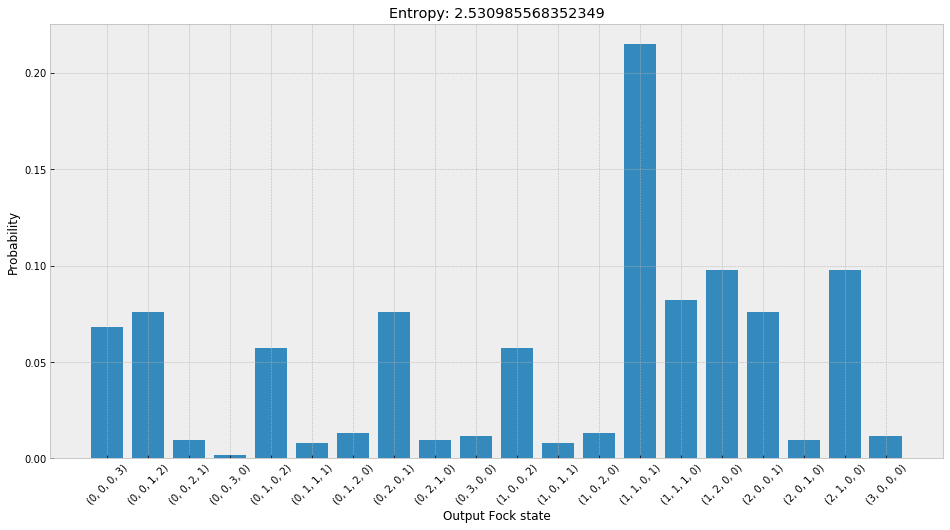

In [176]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.bar(list(res.keys()), list(res.values()))
ax.set_xticklabels(list(res.keys()), rotation = 45)
ax.set_ylabel("Probability")
ax.set_xlabel("Output Fock state")
ax.set_title("Entropy: " + str(ent))
plt.show()
plt.close(fig)

In [141]:
import multiprocessing as mp
from functools import partial

def simulation(programme, i):
    engine = sf.Engine(
        backend="fock",
        backend_options={"cutoff_dim": 4})
    
    res1 = engine.run(programme).samples[0]
    res2 = engine.run(programme).samples[0]

    res1 = convert_binary(res1)
    res2 = convert_binary(res2)

    return von_neumann_prot(res1, res2)

def convert_binary(array):
    array[np.where(array > 0)[0]] = 1
    return array

def von_neumann_prot(input1, input2):
    output_res = ''
    for i in range(len(input1)):
        if input1[i] == input2[i]:
            continue
        else:
            digit = abs(input1[i]*(input2[i]-1))
            output_res = output_res + str(digit)
    return output_res



In [164]:
mp_func = partial(simulation, boson_sampling_meas)

pool = mp.Pool(10)
N = 300
res = pool.map(mp_func, range(N))
pool.terminate()
pool.join()
pool.close()

In [165]:
res = filter(lambda i: i != '', res)

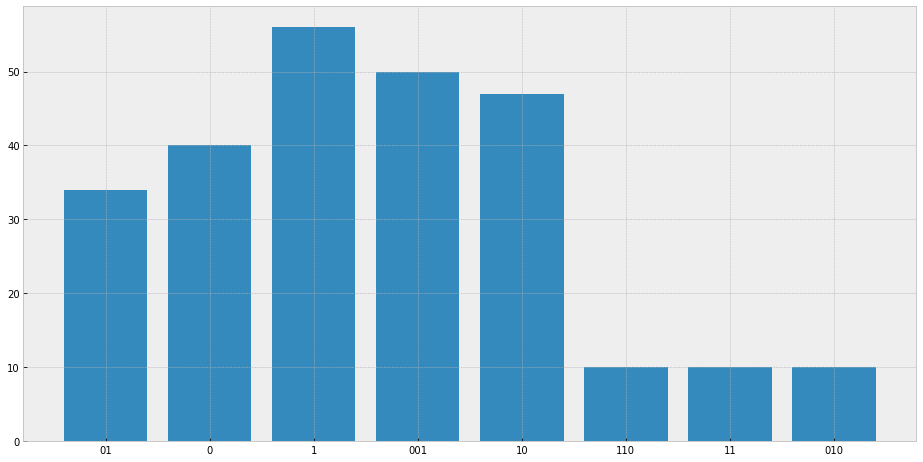

In [166]:
res = Counter(res)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.bar(list(res.keys()), list(res.values()))
plt.show()
plt.close(fig)